Examine tidal constituents - M2/K1 elevation

M2/K1 tidal currents are also examined at the VENUS nodes.

Inference for P1 and K2 is not applied

Comparing background visc = 1e-4, 1e-5, and 1e-6. 

Simulations had no weather, isoneutral lateral mixing.

In [1]:
# imports
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import netCDF4 as nc
from salishsea_tools import tidetools
from salishsea_tools import viz_tools
from salishsea_tools import bathy_tools
import pandas as pd
import datetime
from dateutil import tz
import os
import angles

from salishsea_tools import ellipse

from __future__ import division

# Run Details

In [2]:
# pathname for data 
path = '/data/nsoontie/MEOPAR/SalishSea/results/tides/'

#the runs we want to analyze
runs = ['visc1e-4', 'visc1e-5', 'visc1e-6']

# grid
grid = nc.Dataset('/ocean/imachuca/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

# Observations

In [3]:
filename = '/data/nsoontie/MEOPAR/analysis/compare_tides/obs_tidal_wlev_const_all.csv'


harm_obs = pd.read_csv(filename,sep=';',header=0)
harm_obs = harm_obs.rename(columns={'Site': 'site', 'Lat': 'lat', 'Lon': 'lon', 
                                    'M2 amp': 'M2_amp', 'M2 phase (deg UT)': 'M2_pha',
                                   'K1 amp': 'K1_amp', 'K1 phase (deg UT)': 'K1_pha'})


This is a list of observations that we can compare with our model output. Now we have a struc object called harm_obs that contains the data printed above.

In [4]:
filename = '/data/nsoontie/MEOPAR/analysis/Idalia/other_constituents.csv'

harm_other = pd.read_csv(filename,sep=',',header=0)
harm_other = harm_other.rename(columns={'Site': 'site', 'Lat': 'lat', 'Lon': 'lon', 
                                    'O1 amp': 'O1_amp', 'O1 phase (deg UT)': 'O1_pha',
                                    'P1 amp': 'P1_amp', 'P1 phase (deg UT)': 'P1_pha',
                                    'Q1 amp': 'Q1_amp', 'Q1 phase (deg UT)': 'Q1_pha',
                                    'S2 amp': 'S2_amp', 'S2 phase (deg UT)': 'S2_pha',
                                    'N2 amp': 'N2_amp', 'N2 phase (deg UT)': 'N2_pha',
                                    'K2 amp': 'K2_amp', 'K2 phase (deg UT)': 'K2_pha'})

# Model

We don't have model output at all of the above locations. The model outputs are listed below. There is a location.nc file in the run directory for each of the stations listed below.

For some reason, the iodef file I used had fewer stations than our previous analaysis...

In [5]:
stations_obs =  ['Port Renfrew','Sheringham Point', 'Sooke','Pedder Bay','Esquimalt',
                   'Victoria','Clover Point','Finnerty Cove','Fulford Harbour',
                    'Tumbo Channel','Patos Island','Whaler Bay', 'Tsawwassen',
                   'Sandheads', 'Point Grey','Point Atkinson','Gibsons Landing',
                    'Halfmoon Bay','Irvines Landing','Powell River', 'Lund',
                    'Twin Islets','Campbell River','Maude Island E', 'Nymphe Cove',
                    'Seymour Narrows','Brown Bay','Chatham Point','Kelsey Bay','Yorke Island']

0 Port Renfrew
1 Sheringham Point
2 Sooke
3 Pedder Bay
4 Esquimalt
5 Victoria
6 Clover Point
7 Finnerty Cove
8 Fulford Harbour
9 Tumbo Channel
10 Patos Island
11 Whaler Bay
12 Tsawwassen
13 Sandheads
14 Point Grey
15 Point Atkinson
16 Gibsons Landing
17 Halfmoon Bay
18 Irvines Landing
19 Powell River
20 Lund
21 Twin Islets
22 Campbell River
23 Maude Island E
24 Nymphe Cove
25 Seymour Narrows
26 Brown Bay
27 Chatham Point
28 Kelsey Bay
29 Yorke Island


[-126.1, -122, 47, 51]

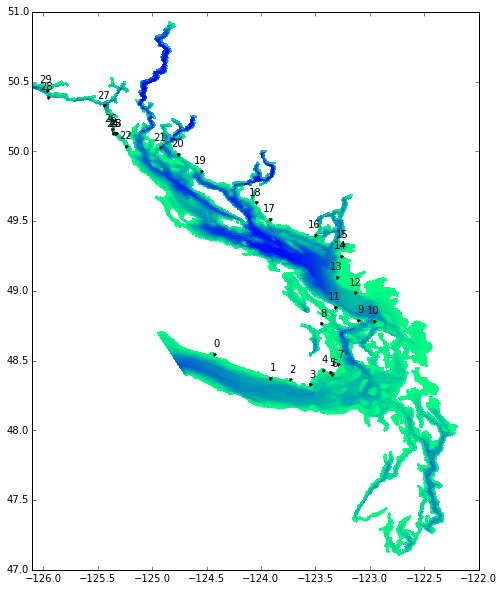

In [6]:
fig,ax=plt.subplots(1, 1, figsize=(8, 10))
ax.pcolormesh(X,Y,bathy,cmap='winter_r')
numsta=len(stations_obs)
for stn in range(numsta):
    location = stations_obs[stn]
    lon=-harm_obs.lon[harm_obs.site==location]
    lat=harm_obs.lat[harm_obs.site==location]
    ax.plot(lon,lat,'.k',label=location)
    ax.annotate(stn, xy = (lon,lat), xytext = (5,5),ha = 'right', va = 'bottom',
        textcoords = 'offset points')
    print stn, location
    
ax.axis([-126.1,-122,47,51])

# Tidal Elevation Harmonics

We need a way of determing the amplitude and phase of the main constituents. We will do this using some functions in tidetools. 

First, define the nodal corrections used by nemo. 

In [7]:
#from ocean.output
# Simulation reftime October 26, 2002
NodalCorr = {
    'K1': {
        'ft': 1.050578,
        'uvt': 296.314842},
    'M2': {
        'ft': 0.987843,
        'uvt': 245.888564},
    'O1': {
        'ft': 1.081364,
        'uvt': 312.950020},
    'S2': {
        'ft': 1.000000,
        'uvt':  0.000000},
    'P1': {
        'ft': 1.000000,
        'uvt': 55.794860},
    'N2': {
        'ft': 0.987843,
        'uvt': 353.570277},
    'Q1': { 
        'ft': 1.081364,
        'uvt': 60.631733},
    'K2': {
        'ft': 1.114095,
        'uvt': 52.129248},
    'reftime': datetime.datetime(2002, 10, 26, tzinfo=tz.tzutc())
    }
nconst=8

Do the harmonic analysis using Muriel's functions

In [8]:
elev ={}

for run in runs:
    elev[run] = {}
    for stn in stations_obs:
        stn_mod = stn.replace(" ", "")
        f = nc.Dataset(os.path.join(path, run,'{}.nc'.format(stn_mod)))
        ssh = f.variables['sossheig'][:]
        time = f.variables['time_counter'][:]/3600.
        tide_fit = tidetools.fittit(ssh,time,nconst)
        
        #apply nodal corrections
        for const in tide_fit:
            tide_fit[const]['phase'] =  tide_fit[const]['phase'] +NodalCorr[const]['uvt']
            tide_fit[const]['amp'] = tide_fit[const]['amp'] / NodalCorr[const]['ft']
            tide_fit[const]['amp'], tide_fit[const]['phase'] = tidetools.convention_pha_amp(
                tide_fit[const]['amp'], tide_fit[const]['phase'])
        elev[run][stn] = tide_fit

Function for calculating complex difference.

In [9]:
def complex_diff(Ao,go,Am,gm):
    #calculates complex differences between observations and model
    #Ao, go - amplitude and phase from observations
    #Am, gm - amplitude and phase from model
    D = np.sqrt((Ao*np.cos(np.pi*go/180)-Am*np.cos(np.pi*gm/180))**2 + 
                (Ao*np.sin(np.pi*go/180)-Am*np.sin(np.pi*gm/180))**2)
    
    return D

Compare between simulations

In [10]:
def compare_elevation(const, runs):
    """compares the amplitude, phase and complex differences of const
    for several simulations listed in runs"""
    
    fig,axs=plt.subplots(1,3,figsize=(15,3))
    for run in runs:
        model_amps =[]; 
        model_phases =[]; 
        cdiffs = []
        for n, stn in enumerate(stations_obs):
            #Observations
            try:
                obs_amp = harm_obs[harm_obs.site==stn]['{}_amp'.format(const)].values[0]/100
                obs_phase = harm_obs[harm_obs.site==stn]['{}_pha'.format(const)].values[0]
            except KeyError:
                try:
                    obs_amp = harm_other[harm_other.site==stn]['{}_amp'.format(const)].values[0]/100
                    obs_phase = harm_other[harm_other.site==stn]['{}_pha'.format(const)].values[0]
                except IndexError:
                    obs_amp = float('NaN')
                    obs_phase= float('NaN')
            
            #Model
            model_amp = elev[run][stn][const]['amp'][0][0]
            model_phase = angles.normalize(elev[run][stn][const]['phase'][0][0])
            model_amps.append(model_amp/obs_amp) 
            model_phases.append(model_phase-obs_phase)

            #Calculate complex difference
            cdiffs.append(complex_diff(obs_amp, obs_phase, model_amp, model_phase))

        #plotting
        ax=axs[0]
        ax.plot(np.arange(numsta), model_amps,'-o',label=run)
        ax.set_ylabel('Amplitude Ratio (model/obs)')
        ax.set_title('{} amplitude'.format(const))

        ax=axs[1]
        ax.plot(np.arange(numsta), model_phases,'-o', label=run)
        ax.set_ylabel('Phase difference (model-obs, deg)')
        ax.set_title('{} phase'.format(const))

        ax=axs[2]
        ax.plot(np.arange(numsta), cdiffs,'-o', label=run)
        ax.set_ylabel('Complex difference [m]')
        ax.set_title('{} complex differences'.format(const))
    
        print '{} mean complex diff: {} Exluding North {}'.format(run, np.nanmean(cdiffs), np.nanmean(cdiffs[0:25]))
        #Exluding North means does not include anything Seymour Narrows and north of that
    for ax in axs:
        ax.grid()
        ax.legend(loc=0)
        ax.set_xlabel('Station')
        
    return fig

### M2

visc1e-4 mean complex diff: 0.0960172194849 Exluding North 0.0805605888277
visc1e-5 mean complex diff: 0.0959017375973 Exluding North 0.0804110514654
visc1e-6 mean complex diff: 0.0958942561324 Exluding North 0.0804011977988


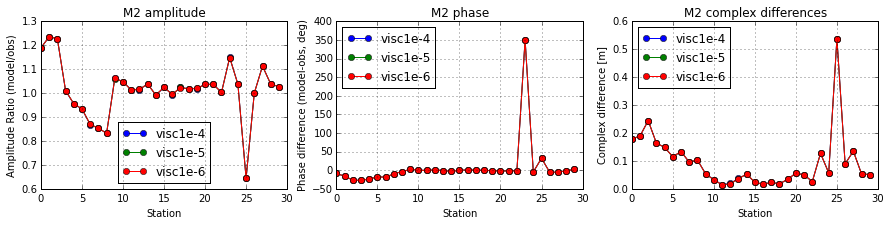

In [11]:
fig = compare_elevation('M2', runs)

###K1

Almost no change in M2/K1 elevation harmonics

visc1e-4 mean complex diff: 0.0662783479258 Exluding North 0.0631727434823
visc1e-5 mean complex diff: 0.0663612982932 Exluding North 0.0632608013372
visc1e-6 mean complex diff: 0.0664078816267 Exluding North 0.0633148076545


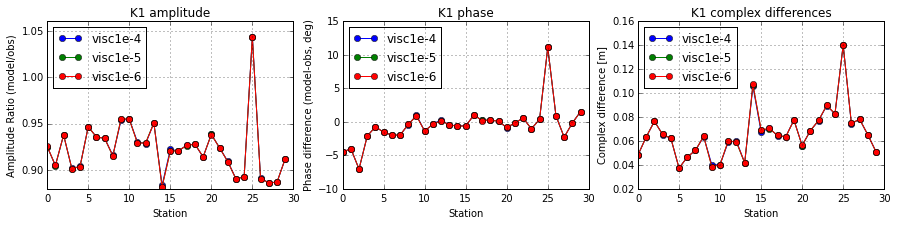

In [12]:
fig = compare_elevation('K1', runs)

###S2

visc1e-4 mean complex diff: 0.0380954185312 Exluding North 0.0233833032568
visc1e-5 mean complex diff: 0.0379143630249 Exluding North 0.0231329907998
visc1e-6 mean complex diff: 0.0379018048499 Exluding North 0.0231213369909


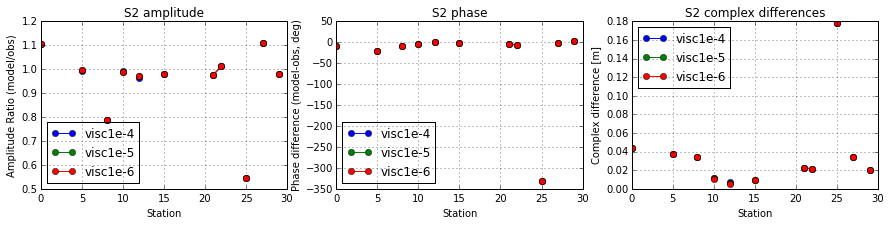

In [13]:
fig = compare_elevation('S2', runs)

###O1

visc1e-4 mean complex diff: 0.0610522918155 Exluding North 0.0571953378471
visc1e-5 mean complex diff: 0.0611304474207 Exluding North 0.0573024420613
visc1e-6 mean complex diff: 0.0611505824717 Exluding North 0.0573289354017


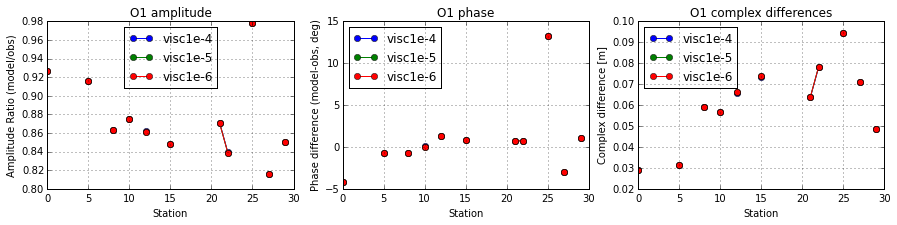

In [14]:
fig = compare_elevation('O1', runs)

##Summary

* The background vertical viscosity has almost no effect on the tidal elevation. 
* In terms of complex differences, there is a slight improvement in the semi-diurnals and a slight degradation of the diurnals. But the changes in the mean complex difference over all stations is typically less than one mm.  

# Tidal Currents

Do the harmonic analysis using Muriel's functions

In [15]:
curr = {}

nodes = ['east', 'central', 'delta']

for run in runs:
    curr[run] = {}
    for node in nodes:
        f = nc.Dataset(os.path.join(path,run,'VENUS_{}_gridded.nc'.format(node)))
        u = f.variables['vozocrtx'][:]
        v = f.variables['vomecrty'][:]
        dep = f.variables['depthu'][:]
        t = f.variables['time_counter'][:]/3600.
        
        u_rot,v_rot = ellipse.prepare_vel(u, v)
        
        params = ellipse.get_params(u_rot, v_rot, t, nconst, tidecorr = NodalCorr)
        curr[run][node] = params

##Comparisons

### Observations

taken from /home/nsoontie/Documents/Muriel/Mark_Currents_Nodes.png

In [16]:
codar ={'east' : {
        'M2': 
        {
        'Semi-Major Axis': 0.138,
        'Semi-Minor Axis': -0.037,
        'Inclination': 134,
        'Phase': 282},
        'K1':
        {
        'Semi-Major Axis': 0.077,
        'Semi-Minor Axis': -0.009,
        'Inclination': 129,
        'Phase': 187}
        },
        'central' : {
        'M2': {
        'Semi-Major Axis': 0.113,
        'Semi-Minor Axis': 0.008,
        'Inclination': 126,
        'Phase': 273},
        'K1':
        {
        'Semi-Major Axis': 0.074,
        'Semi-Minor Axis': 0.006,
        'Inclination': 134,
        'Phase': 131}
        }
        }
       

In [17]:
def compare_currents(const, runs, eparams, units, xlims,nodes):
    """compares tidal currents of a constituent near the surface for simulations in runs
    The ellipse parameters in eparams are compared
    Comparisons carried out at locations listed in nodes
    xlims are the limits of the x axis associated with eparams
    units are the units associated with eparams"""
    fig,axs = plt.subplots(len(nodes),len(eparams),figsize=(5*len(eparams), 4.5*len(nodes)))
    row=0
    for eparam, xlim, unit, in zip(eparams, xlims, units):
        for node, ax in zip(nodes, axs[:,row]):
            for run in runs:
                ax.plot(curr[run][node][const][eparam][:,0,0], dep, label=run)
            ax.plot(codar[node][const][eparam],0,'o',label='observations')
            ax.legend(loc=0)
            ax.set_title(node)
            ax.grid()
            ax.set_ylim([50,0])
            ax.set_xlim(xlim)
            ax.set_xlabel('{} [{}]'.format(eparam,unit))
            ax.set_ylabel('Depth [m]')
        row=row+1
        
    return fig

###M2

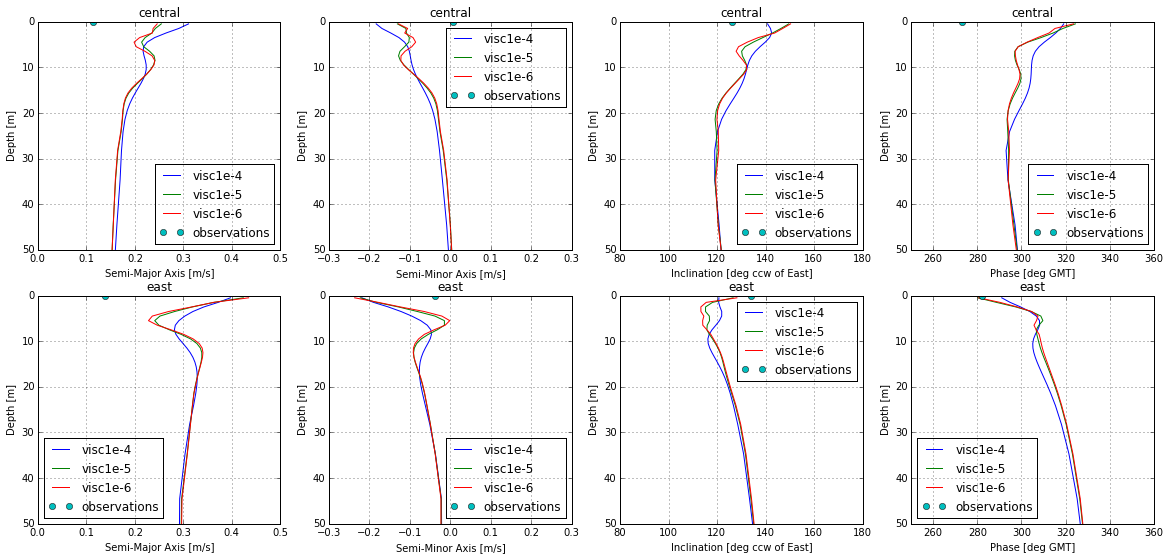

In [18]:
const='M2'
eparams = ['Semi-Major Axis', 'Semi-Minor Axis', 'Inclination', 'Phase']
units = ['m/s', 'm/s', 'deg ccw of East', 'deg GMT']
xlims = [[0,.5], [-.3,.3], [80,180]  , [250, 360]]
nodes= ['central', 'east']
fig = compare_currents(const, runs, eparams, units, xlims, nodes)

**Note:** The observations were analyzed over a much longer time period and a different time of year. 
* Surface  layer is very much affected by the background viscsoity. At depth, the profiles are almost identical. 
* Central 
    * surface major and minor axis decreased with lower viscosity (closer to obs)
* East
    * surface major and minor axis increased with lower viscsoity (farther from obs)
    * large vertical gradients above 10m in both the major and minor axis 

   
    
Why are 1e-5 and 1e-6 so similar but 1e-4 is different. Look into Stephanie's suggestions... maybe 1e-4 is just too high and the gls never kicks in here... I don't know if I saved these values in this sim

Could also look into decreasing the background diffusivity, depending on the value of the diff in the surface layer.

##K1

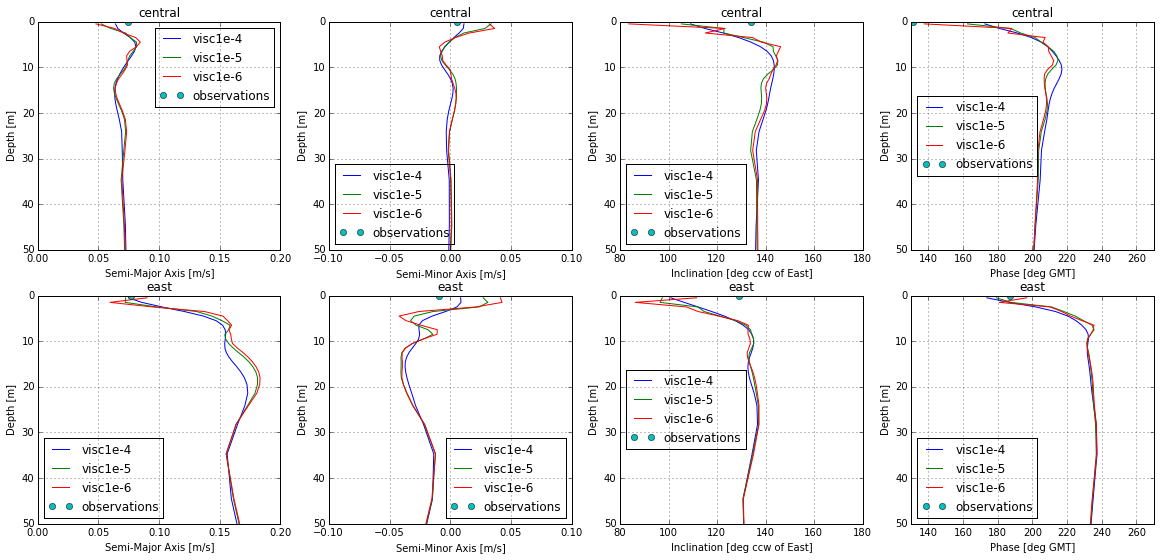

In [19]:
const='K1'
eparams = ['Semi-Major Axis', 'Semi-Minor Axis', 'Inclination', 'Phase']
units = ['m/s', 'm/s', 'deg ccw of East', 'deg GMT']
xlims = [[0,.2], [-.1,.1], [80,180]  , [130, 270]]

fig = compare_currents(const, runs, eparams, units, xlims, nodes)

* Surface layer looks noisier than M2, especially with 1e-6.
* Note: Axis limits are smaller than the the M2 plots 
* Central
    * decrease in semi-major, increase in semi-minor
    * large changes in the inclination and phase (1e-6). Should the inclination really be that much different from the inclination at depth? Observations have 112 (depth averaged) and 134 (surface). But remember there can be errors with the compass of the node...
    * Observed phase is 188 (depth averaged) and 131 (CODAR) 
* East
    * Semi-minor axis increase but is still very small.

#Summary

* It is likely that our background vertical viscosity is too high. Next, I will look at our values in these regions for the 1e-4 and 1e-6 cases (and maybe 1e-5 if I have one). I think I have some deep water renewal cases that I could use. 
* Modifying the backgound vertical viscosity has a big effect on the tidal currents near the surface (upper 20m). There is not much impact at depth.
* Decreasing the background viscosity does not, necessarily, bring us closer to the observations. 
    * The M2 major/minor at central decreased, which is closer to obs
    * The M2 major/minor at east increased, which is further from obs
BUT keep in mind that the observations were analyzed over a different length of time (10-11 vs one month in the model) so we should be careful with this comparison. Our tidal run is in April and uses climatological river so the fresh water influence is stronger than the observations which were anlayzed over 10-11 months (according to an email from Mark but it might be worthwhile to double check). Regardless, the trend is that smaller background viscosity = larger M2 surface (0.5m) currents at east and smaller M2 surface currents at central. What does this mean for across strait velcoities?
* Question - The observed drifter tracks did not appear to be tidal. So should we also be looking at the 'mean' current in our analysis and its sensitivity to the vertical viscosity?